In [3]:
print("""
@Description: Supervised data compression via linear discriminant analysis
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-06-09 10:58:25
""")


@Description: Supervised data compression via linear discriminant analysis
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-06-09 10:58:25



In [22]:
import sys
sys.path.append('./')
sys.path.append('../')
from data.get_data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
dl = DataLoader()
df_wine = dl.get_wine()
X_train, X_test, y_train, y_test = dl.get_train_test(test_size=.3, random_state=0)

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']

# Supervised data compression via linear discriminant analysis

## The inner workings of linear discriminant analysis

In [7]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV {0}: {1}'.format(label, mean_vecs[label-1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]
MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]
MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]


In [8]:
d = 13
S_W = np.zeros(shape=(d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    x_i = X_train_std[y_train == label] - mv
    class_scatter = (x_i[:, :, np.newaxis] * x_i[:, np.newaxis, :]).sum(axis=0)
    # i think `for` loop is not a good choice, so write this in broadcast
    # class_scatter = np.zeros_like(S_W)
    # for row in X_train_std[y_train == label]:
    #     row, mv = row.reshape(d, 1), mv.reshape(d, 1)
    #     class_scatter += (row-mv).dot((row - mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: {0}x{1}'.format(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [9]:
print('Class label distribution:', np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


In [10]:
d = 13
S_W = np.zeros(shape=(d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print(f'Scaled within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


In [11]:
mean_overall = np.mean(X_train_std, axis=0).reshape(d, 1)
S_B = np.zeros(shape=(d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print(f'Between-class scatter matrix: {S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


## Selecting linear discriminants for the new feature subspace

In [12]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:
452.72158124497446
156.43636121952335
5.503104421401319e-14
3.8652392635319325e-14
3.8652392635319325e-14
3.005981742749635e-14
3.005981742749635e-14
2.842170943040401e-14
1.8734299260090266e-14
8.603058794745034e-15
8.603058794745034e-15
4.4663109053582805e-15
4.4663109053582805e-15


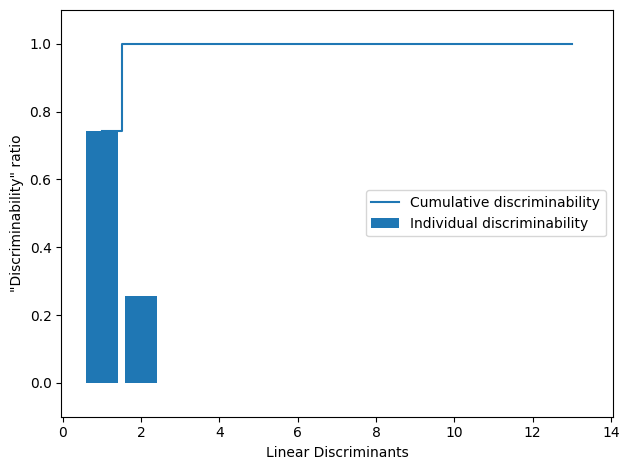

In [13]:
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, align='center', label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative discriminability')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


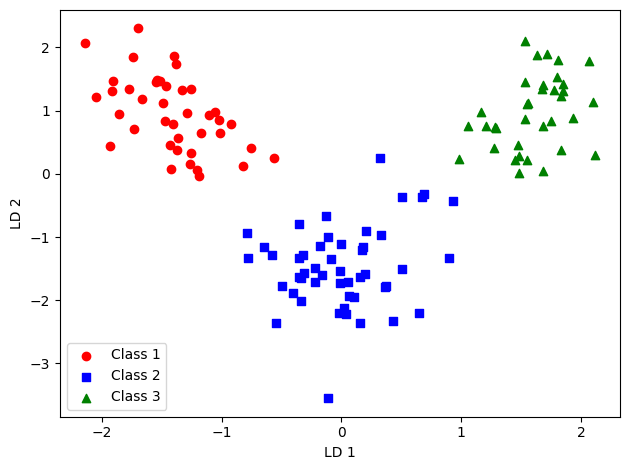

In [15]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1]*(-1),
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend()
plt.tight_layout()
plt.show()

## LDA via scikit-learn

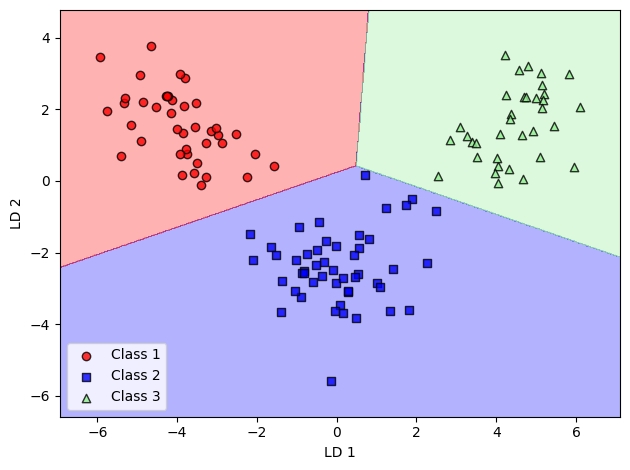

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend()
plt.tight_layout()
plt.show()

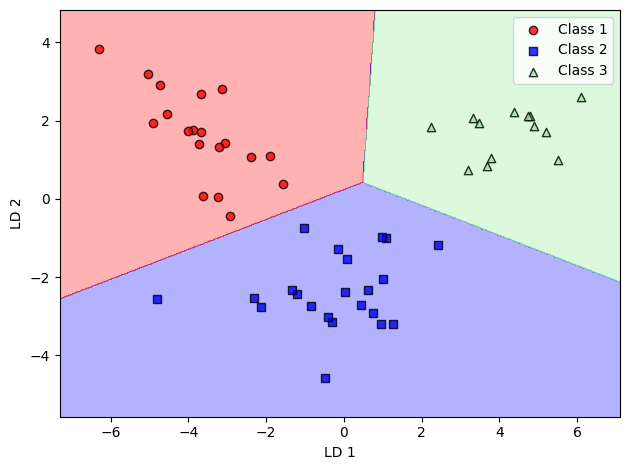

In [32]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
X_test.shape

(54, 13)